### In this nb we will seek to make the analysis in Exploratory2 more robust by doing a more thorough cleaning of the time series data to remove influence of seasonality and changing variance. We will also compare our simple regression with the impulse response from a VAR model.

In [1]:
from utils import *

<AxesSubplot:xlabel='date'>

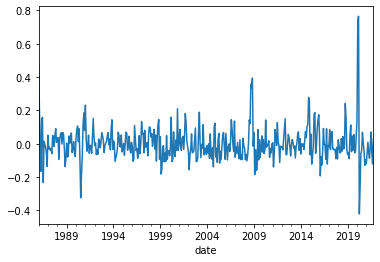

In [2]:
wti = pd.read_csv('data/WTI.csv', parse_dates=True, index_col='date', dayfirst=True)['spot'].pct_change().dropna()
wti.plot()

In [3]:
av = wti.groupby(wti.index.year).std()
print(len(av))

36


In [4]:
wti_av = wti.index.map(lambda x: av.loc[x.year])
print(len(wti_av) == len(wti))

True


In [5]:
wti = wti/wti_av

<AxesSubplot:xlabel='date'>

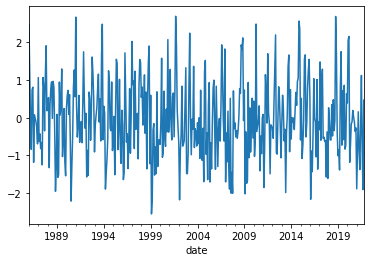

In [6]:
wti.plot()

<AxesSubplot:xlabel='date'>

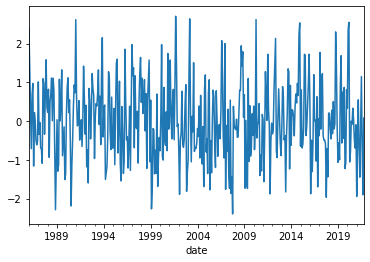

In [7]:
ma = wti.groupby(wti.index.month).mean()
wti_ma = wti.index.map(lambda x: ma.loc[x.month])
wti = wti - wti_ma
wti.plot()

<AxesSubplot:xlabel='date'>

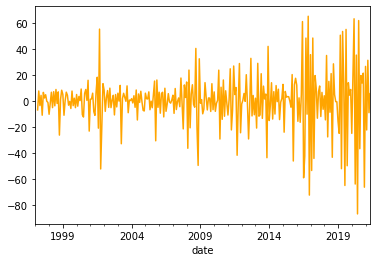

In [8]:
epu = pd.read_csv('data/EPUGlobal.csv', parse_dates=True, index_col='date', dayfirst=True)
epu['MA2'] = epu.GEPU_current.rolling(2).mean()
epu_shock = (epu.GEPU_current - epu.MA2).diff()
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

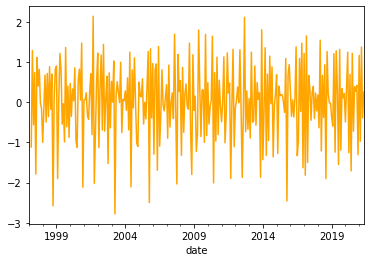

In [9]:
av1 = epu_shock.groupby(epu_shock.index.year).std()
epu_av = epu_shock.index.map(lambda x: av1.loc[x.year])
epu_shock = epu_shock/epu_av
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

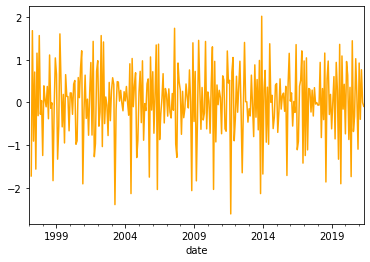

In [10]:
ma1 = epu_shock.groupby(epu_shock.index.month).mean()
epu_ma = epu_shock.index.map(lambda x: ma1.loc[x.month])
epu_shock = epu_shock - epu_ma
epu_shock.plot(color='orange')

In [11]:
df = pd.DataFrame(wti.rename('wti')).join(epu_shock.rename('epu_shock')).dropna()
df.head()

,wti,epu_shock
date,,
2021-05-01,-1.447284,-0.091700
2021-04-01,-0.708349,0.000687
2021-03-01,0.548346,0.765670
2021-02-01,-0.545331,-0.396248
2021-01-01,-1.947965,0.922549


In [12]:
model1 = news_regression('wti', 'epu_shock', df)
model1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wti   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.998
Date:                Wed, 29 Dec 2021   Prob (F-statistic):             0.0212
Time:                        01:10:53   Log-Likelihood:                -390.90
No. Observations:                 279   AIC:                             809.8
Df Residuals:                     265   BIC:                             860.6
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0083      0.060     -0.137      0.891      -0.127       0.110
epu_shock-lag0     -0.1605      0.092     -1.745      0.082      -0.342       0.021
epu_shock-lag1     -0.3860      0.125     -3.093      0.002      -0.632      -0.140
epu_shock-lag2     -0.4965      0.155     -3.208      0.002      -0.801      -0.192
epu_shock-lag3     -0.3723      0.167     -2.232      0.026      -0.701      -0.044
epu_shock-lag4     -0.2656      0.180     -1.476      0.141      -0.620       0.089
epu_shock-lag5      0.0360      0.183      0.197      0.844      -0.324       0.396
epu_shock-lag6      0.0313      0.189      0.165      0.869      -0.342       0.404
epu_shock-lag7      0.1539      0.187      0.822      0.412      -0.215       0.522
epu_shock-lag8      0.0886      0.176      0.503      0.616      -0.259       0.436
epu_shock-lag9     -0.0502      0.171     -0.294      0.769      -0.387       0.286
epu_shock-lag10     0.0722      0.150      0.482      0.630      -0.223       0.367
epu_shock-lag11     0.0218      0.128      0.170      0.865      -0.230       0.273
epu_shock-lag12  4.221e-05      0.094      0.000      1.000      -0.185       0.185
==============================================================================
Omnibus:                        2.664   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.264   Jarque-Bera (JB):                2.292
Skew:                           0.117   Prob(JB):                        0.318
Kurtosis:                       2.623   Cond. No.                         8.96
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

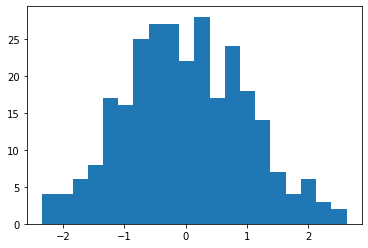

In [13]:
plt.hist(model1.resid, bins=20)
plt.show()

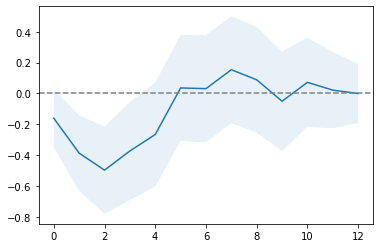

In [14]:
plt.plot(model1.params[1:].reset_index(drop=True))
plt.fill_between([*range(13)], model1.conf_int()[0][1:], model1.conf_int()[1][1:], alpha=.1)
plt.axhline(y=0, color='grey', linestyle='--')

### VAR

In [15]:
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

In [16]:
for l in range(1, 15):
    res = pearsonr(df['wti'].iloc[l:], df['epu_shock'].iloc[:-l])
    print(f'Lag {l}: {res}')

Lag 1: (-0.026301636847725855, 0.6555658485481355)
Lag 2: (-0.1299220788639569, 0.027211400997351975)
Lag 3: (0.005363777463174894, 0.9277857170707577)
Lag 4: (-0.07720205784965568, 0.19219091922197967)
Lag 5: (0.13460700277332238, 0.022797391625006887)
Lag 6: (-0.039099717120016086, 0.5109046573339044)
Lag 7: (0.06272806575175702, 0.29211751282770493)
Lag 8: (0.017292787415588387, 0.772088742089027)
Lag 9: (-0.1023808062381602, 0.08613607609563176)
Lag 10: (0.08440486011296752, 0.15821642461001414)
Lag 11: (-0.02921457977746522, 0.6264210043675037)
Lag 12: (0.0037805590636103906, 0.9498743995529004)
Lag 13: (0.023189403495827682, 0.700271289257842)
Lag 14: (0.01147555587217938, 0.8492042017828147)


In [17]:
model2 = VAR(pd.DataFrame(wti.rename('wti')).join(epu_shock.rename('epu_shock')).dropna()).fit(maxlags=5)
model2.summary()

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Dec, 2021
Time:                     01:10:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.474912
Nobs:                     286.000    HQIC:                 -0.643417
Log likelihood:          -681.505    FPE:                   0.469510
AIC:                    -0.756142    Det(Omega_mle):        0.435375
--------------------------------------------------------------------
Results for equation wti
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.005292         0.058922           -0.090           0.928
L1.wti               0.137229         0.060503            2.268           0.023
L1.epu_shock        -0.225213         0.089714           -2.510   

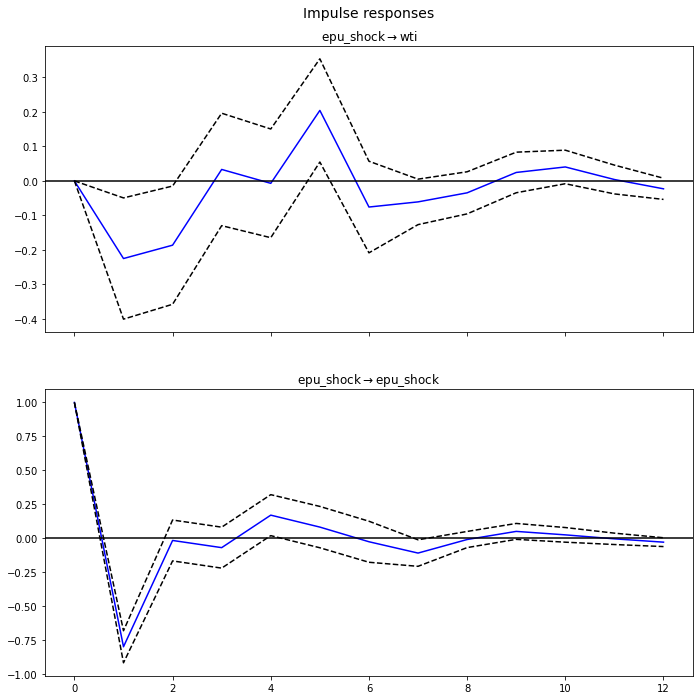

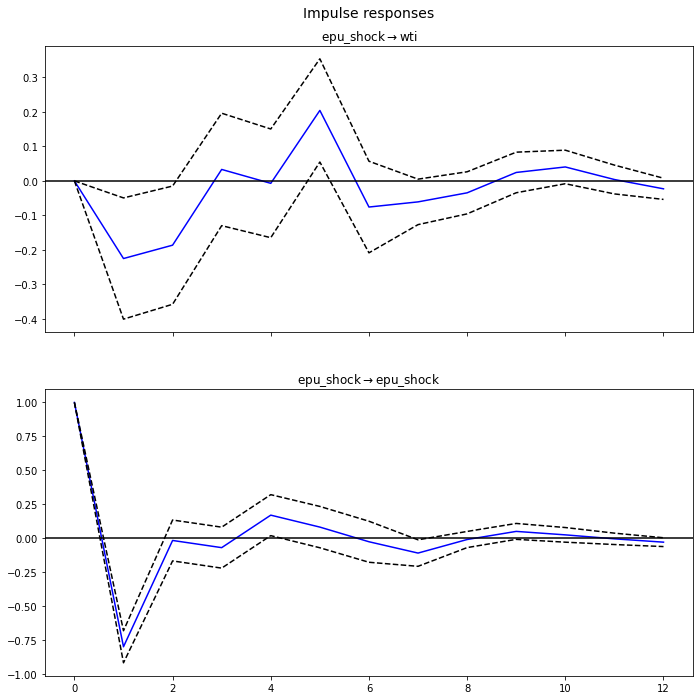

In [20]:
model2.irf(12).plot(impulse='epu_shock')